In [1]:
import pandas as pd 
df = pd.read_csv("Data/syn_fin_ds.csv")
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [2]:
# One-hot encoding for nameOrig and nameDest
df['nameOrig_encoded'] = df['nameOrig'].apply(lambda x: 0 if x.startswith('C') else 1)
df['nameDest_encoded'] = df['nameDest'].apply(lambda x: 0 if x.startswith('C') else 1)

#verifying to check whether this was done successfully
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,nameOrig_encoded,nameDest_encoded
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,0,1
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,0,1
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,0,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,0,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,0,1


Here basically C means Customer and M means Merchant, so wherever we find a transaction originating or destined to C, we change that to 0 and wherever we find a transaction originating or destined to M, we change that to 1 and do this inplace

In [3]:

df.shape


(6362620, 13)

# Obs  
- approximately 6.3 Million Rows (instances)
- 11 atrributes , 4 should be removed , effectively  7 attributes 

# Preprocessing and EDA

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 13 columns):
 #   Column            Dtype  
---  ------            -----  
 0   step              int64  
 1   type              object 
 2   amount            float64
 3   nameOrig          object 
 4   oldbalanceOrg     float64
 5   newbalanceOrig    float64
 6   nameDest          object 
 7   oldbalanceDest    float64
 8   newbalanceDest    float64
 9   isFraud           int64  
 10  isFlaggedFraud    int64  
 11  nameOrig_encoded  int64  
 12  nameDest_encoded  int64  
dtypes: float64(5), int64(5), object(3)
memory usage: 631.1+ MB


In [5]:
# If C -> Customer Account 
# If M -> Merchant Account 
def first_letter(name: str) -> str:
    return name[0:1]

dest_first = df["nameDest"].apply(first_letter)
orig_first = df["nameOrig"].apply(first_letter)

print(len(dest_first.value_counts()))
print(len(orig_first.value_counts()))
df["nameDest"] = dest_first
df["nameOrig"] = orig_first

2
1


What this output means is that nameDest (destination account) has 2 unique first letters both C and M while nameOrig (origin account) has only 1 unique first letter C and this is expected because Customers initiate transaction and it goes to either customer or merchant.

In [6]:
# Drop Cols for the oldbalanceOrg , newbalanceOrig , oldbalanceDest , newbalanceDest -> Data Leakage 
# The fraud transactions are cancelled 
df.drop(columns=["oldbalanceOrg","newbalanceOrig","oldbalanceDest","newbalanceDest"],inplace=True)
df.head()

,step,type,amount,nameOrig,nameDest,isFraud,isFlaggedFraud,nameOrig_encoded,nameDest_encoded
0,1,PAYMENT,9839.64,C,M,0,0,0,1
1,1,PAYMENT,1864.28,C,M,0,0,0,1
2,1,TRANSFER,181.00,C,C,1,0,0,0
3,1,CASH_OUT,181.00,C,C,1,0,0,0
4,1,PAYMENT,11668.14,C,M,0,0,0,1


In [7]:
# step means the time of the day transaction occured 
df["step"].value_counts()

step
19     51352
18     49579
187    49083
235    47491
307    46968
       ...  
725        4
655        4
246        4
662        2
112        2
Name: count, Length: 743, dtype: int64

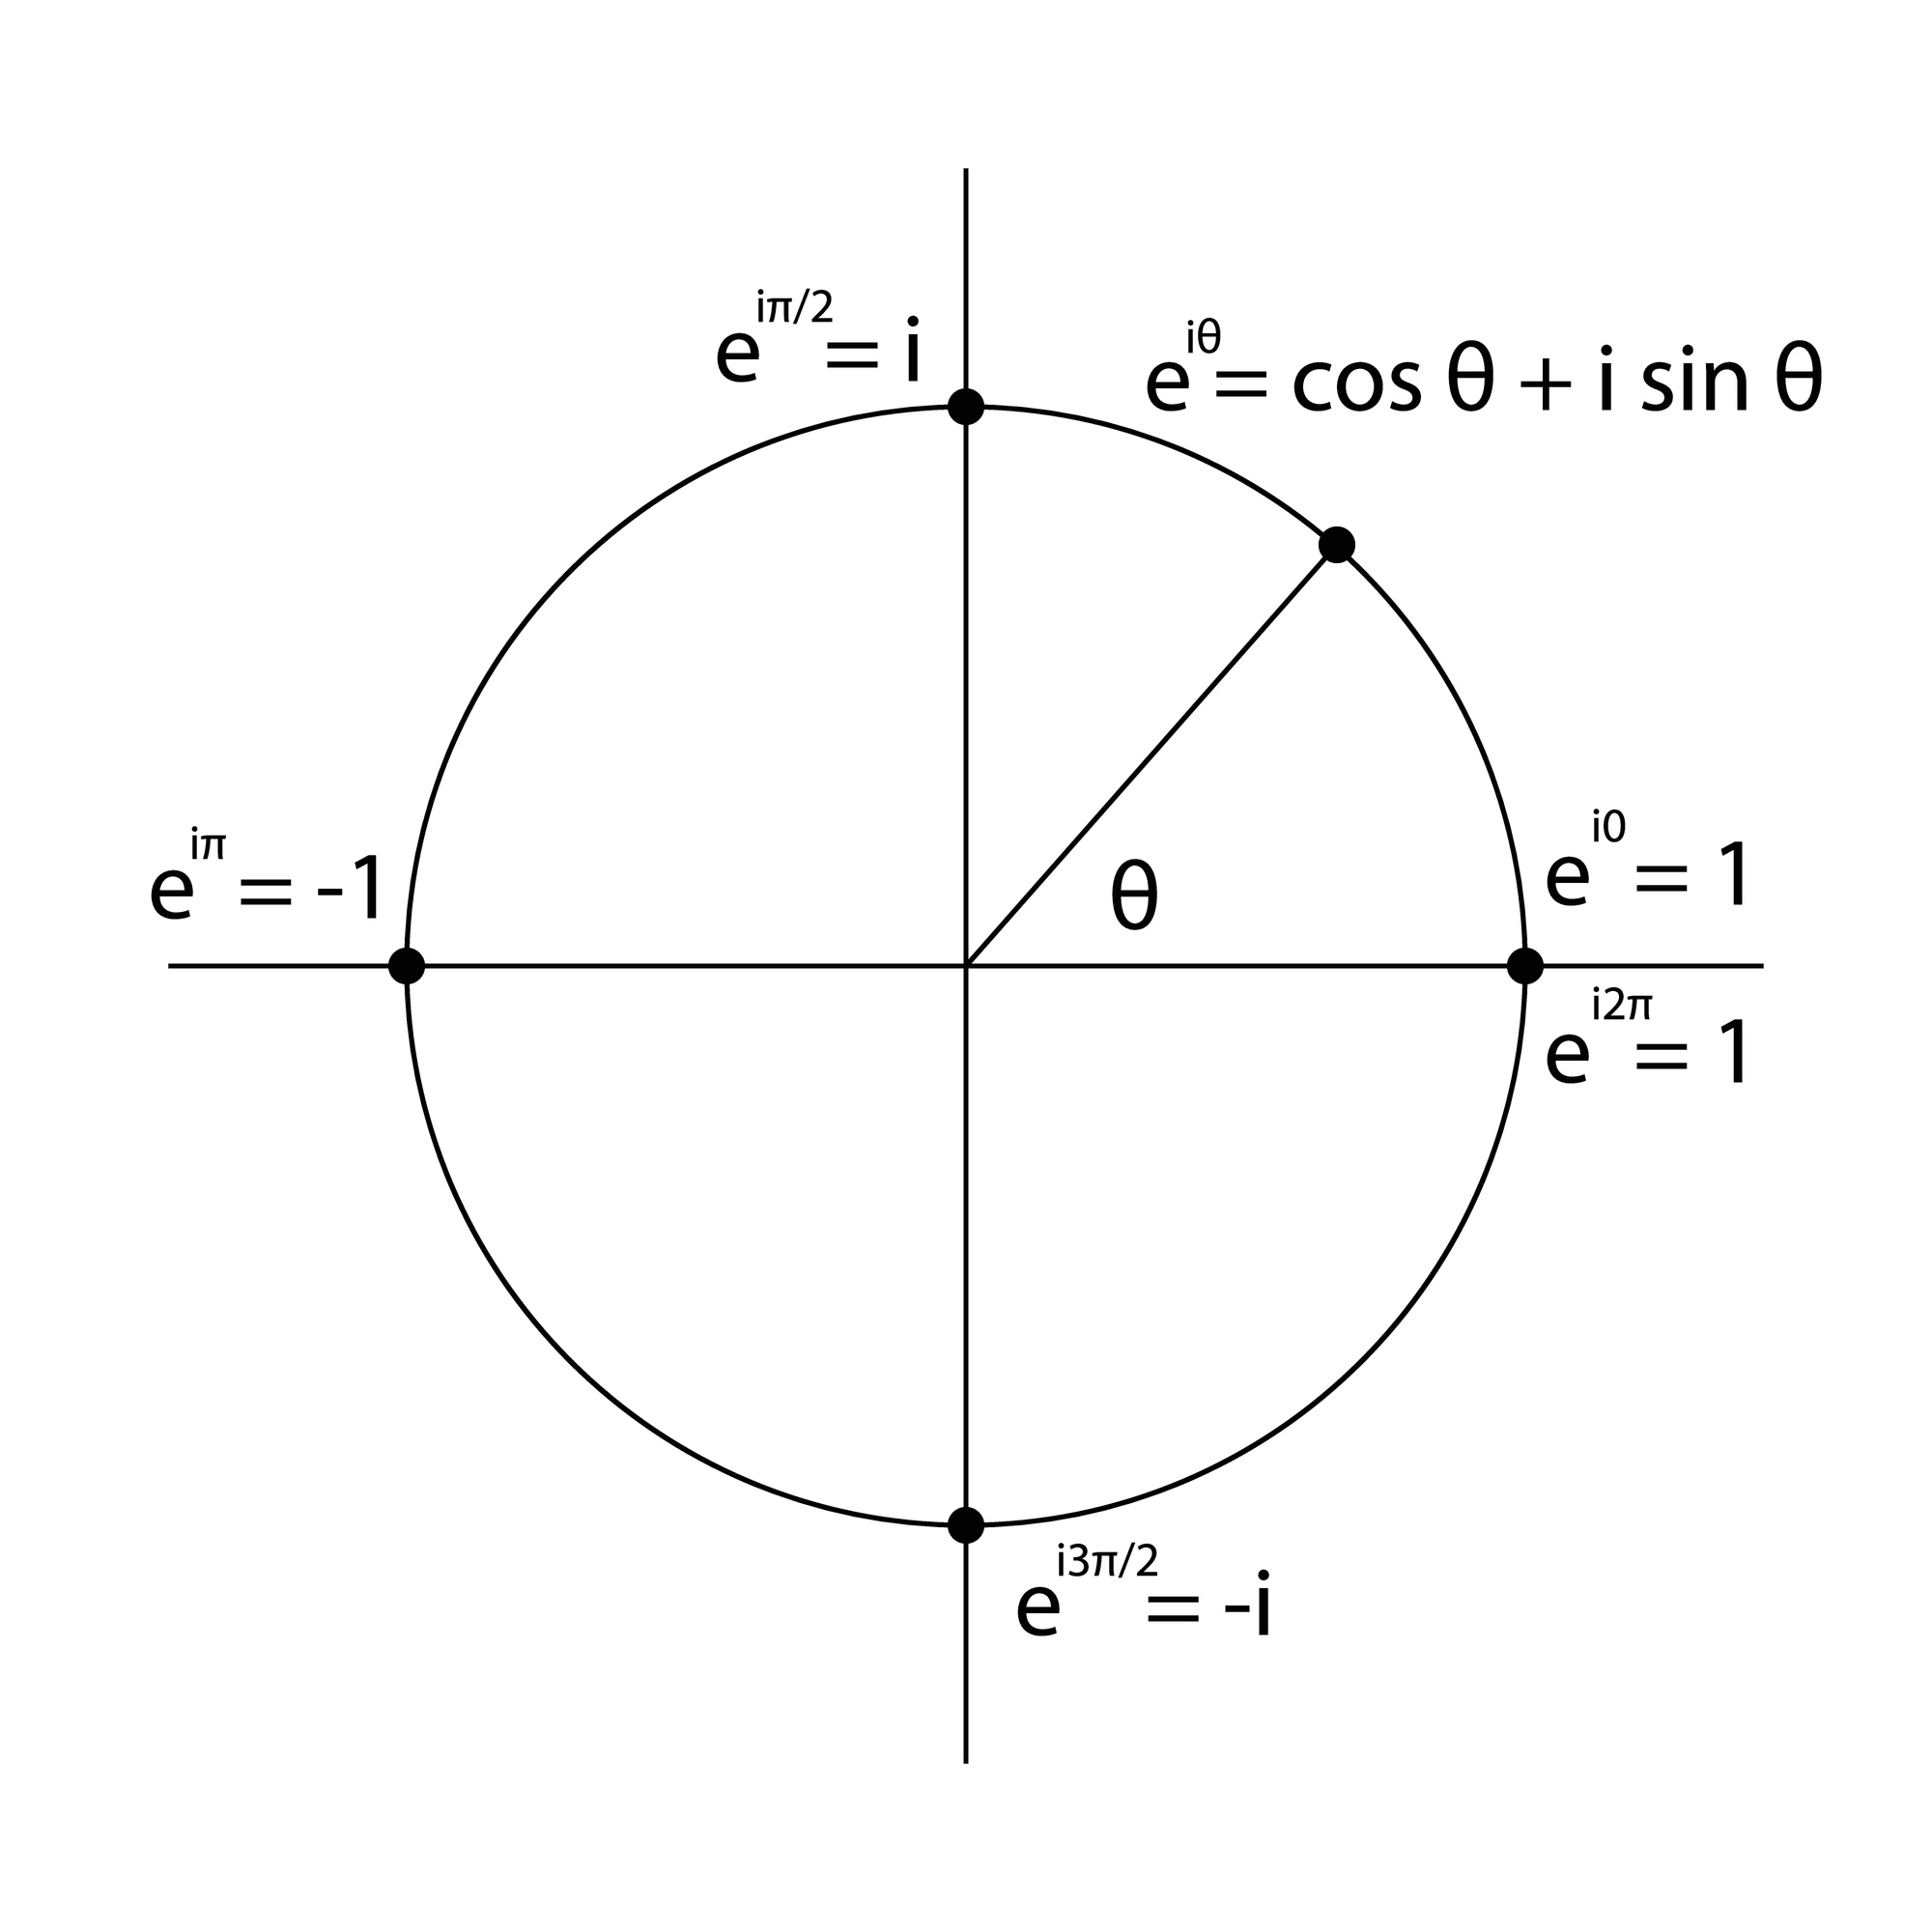

- Solutions : 
> - Convert the time to the 24 hours 
>   - Problem : even the 11 at night is near the 00:00 in the morning , the model will think they are far apart 

- Better Solutions : 
> - Use the Sin and cos for the transformations (see above)

In [8]:
# Create a new feature 'hour_of_day'
# step % 24 gives the remainder when dividing by 24
# step 1 -> 1 % 24 = 1 (1:00 AM)
# step 25 -> 25 % 24 = 1 (1:00 AM)
# step 48 -> 48 % 24 = 0 (Midnight)
df['hour_of_day'] = df['step'] % 24

In [9]:
import numpy as np

# 'hour_of_day' is the column we created in step 1
hours_in_day = 24

# Create the 'hour_sin' feature
df['hour_sin'] = np.sin(2 * np.pi * df['hour_of_day'] / hours_in_day)

# Create the 'hour_cos' feature
df['hour_cos'] = np.cos(2 * np.pi * df['hour_of_day'] / hours_in_day)

df.drop(columns=["hour_of_day","step"],inplace=True)
df.head()

,type,amount,nameOrig,nameDest,isFraud,isFlaggedFraud,nameOrig_encoded,nameDest_encoded,hour_sin,hour_cos
0,PAYMENT,9839.64,C,M,0,0,0,1,0.258819,0.965926
1,PAYMENT,1864.28,C,M,0,0,0,1,0.258819,0.965926
2,TRANSFER,181.00,C,C,1,0,0,0,0.258819,0.965926
3,CASH_OUT,181.00,C,C,1,0,0,0,0.258819,0.965926
4,PAYMENT,11668.14,C,M,0,0,0,1,0.258819,0.965926


In [10]:
df["type"].value_counts()

type
CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: count, dtype: int64

In [11]:
df["isFraud"].value_counts()

isFraud
0    6354407
1       8213
Name: count, dtype: int64

# Observations 
- Data imbalance 
- might give some patterns about the type of transaction being fraud 
- isFlaggedFraud is based on simple business logic (> 200000) -> This could help in making a better model 
> - How ?? 
>   - if it shows correlation with transaction being fraud -> it might just mean that we jsut need to update the numbers to improve the accuracy (not likely - but maybe )
>   - If it does not show anythign this must be removed 

In [12]:
# Let's See how kind of transaction affect the fraud 
print(df.groupby('type')['isFraud'].sum())

type
CASH_IN        0
CASH_OUT    4116
DEBIT          0
PAYMENT        0
TRANSFER    4097
Name: isFraud, dtype: int64


In [13]:
# Lets see how effective the business rule is about finding the fraud Transaction
pd.crosstab(df['isFlaggedFraud'], df['isFraud'])

isFraud,0,1
isFlaggedFraud,,
0,6354407,8197
1,0,16


# Observations 
- It is evident that all the frauds are either in the CASH_OUT or TRANSFER type of transactions 
- It is also evident that the simple business logic that flags everything above 200000 as fraud is definitely not working as it misses 8197 instances 

# Plots

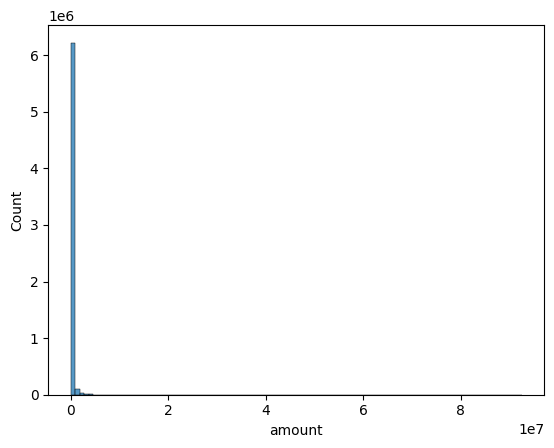

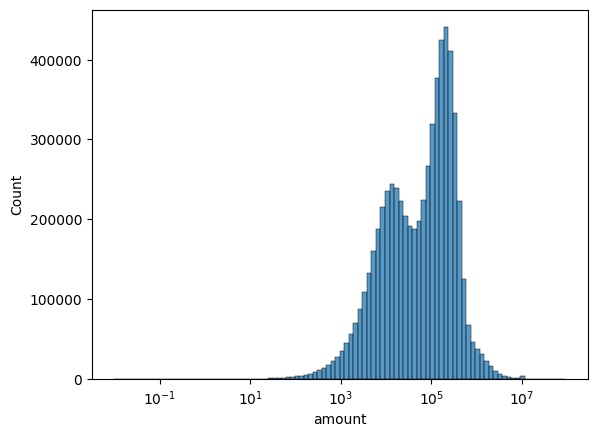

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# This will look squished, showing the skew
sns.histplot(df['amount'], bins=100)
plt.show()

# A log scale plot is much more useful
sns.histplot(df['amount'], bins=100, log_scale=True)
plt.show()

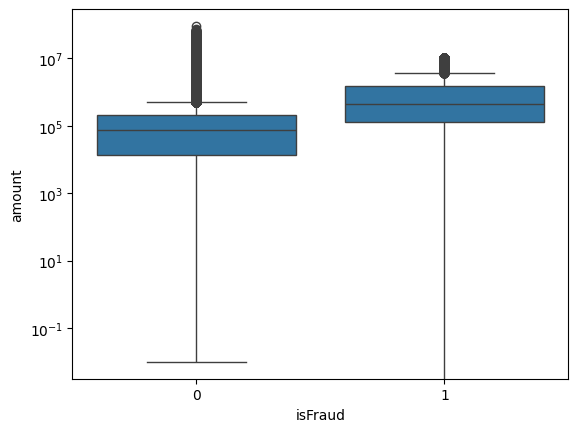

Non-Fraud Stats:
 count    6.354407e+06
mean     1.781970e+05
std      5.962370e+05
min      1.000000e-02
25%      1.336840e+04
50%      7.468472e+04
75%      2.083648e+05
max      9.244552e+07
Name: amount, dtype: float64

Fraud Stats:
 count    8.213000e+03
mean     1.467967e+06
std      2.404253e+06
min      0.000000e+00
25%      1.270913e+05
50%      4.414234e+05
75%      1.517771e+06
max      1.000000e+07
Name: amount, dtype: float64


In [15]:
# Use a log scale on the y-axis to make it readable
sns.boxplot(x='isFraud', y='amount', data=df)
plt.yscale('log') # Use log scale!
plt.show()

# Also check the descriptive statistics
print("Non-Fraud Stats:\n", df[df['isFraud'] == 0]['amount'].describe())
print("\nFraud Stats:\n", df[df['isFraud'] == 1]['amount'].describe())

# Hypothesis Testing

In [16]:
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind, mannwhitneyu, ks_2samp, chi2_contingency
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import cramervonmises_2samp
import matplotlib.pyplot as plt

In [17]:
df = pd.read_csv("Data/syn_fin_ds.csv")
fraud = df[df["isFraud"] == 1]
nonfraud = df[df["isFraud"] == 0]

results = []

In [18]:
fraud.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2,1,TRANSFER,181.0,C1305486145,181.0,0.0,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.0,C840083671,181.0,0.0,C38997010,21182.0,0.0,1,0
251,1,TRANSFER,2806.0,C1420196421,2806.0,0.0,C972765878,0.0,0.0,1,0
252,1,CASH_OUT,2806.0,C2101527076,2806.0,0.0,C1007251739,26202.0,0.0,1,0
680,1,TRANSFER,20128.0,C137533655,20128.0,0.0,C1848415041,0.0,0.0,1,0


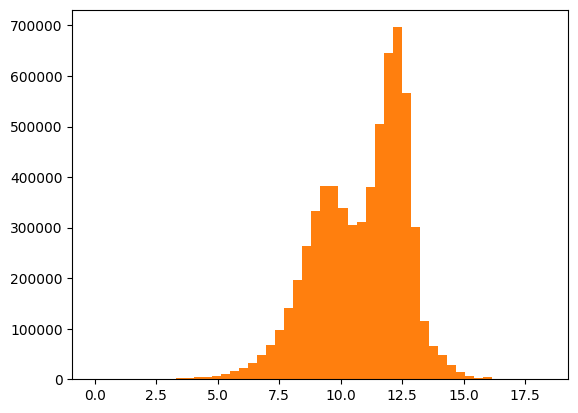

In [19]:
# --- Hypothesis 1: Fraud vs Non-fraud amount ---
# H_0 :The median of the Amount of Fraud Transaction is Same for fraud and non-fraud transactions
# H_1 : The Median of the amount is very different tghan the non-fraud transactions


# Use log transform to reduce skewness -> MAKE THE DATA MORE NORMAL : I have tried taking the log 2-3 times,
# it makes data normal but shifts the data too much right
fraud_amt = (np.log1p(fraud["amount"]))
nonfraud_amt = np.log1p(nonfraud["amount"])

# to visualize the distributions
plt.hist(fraud_amt, bins=50 )
plt.hist(nonfraud_amt, bins=50)

# Mann-Whitney Test (nonparametric)
# This test is used to determine whether there is a significant difference between the distributions of two independent samples.
# p1 is the p-value for the test
stat, p1 = mannwhitneyu(fraud_amt, nonfraud_amt, alternative='two-sided')
results.append(("H1", "Fraud vs Non-fraud Amount", p1))

In [20]:
# --- H2: Transaction type association with fraud ---
# H_0 : The fraud transaction is independent of the transaction type
# H_1 : Certain transaction types are more likely to be fraudulent


# 5x2 Contingency Table
cont_table = pd.crosstab(df["type"], df["isFraud"])
chi2, p2, dof, ex = chi2_contingency(cont_table) # https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chi2_contingency.html

# Cramer's V effect size
n = cont_table.sum().sum()
cramers_v = np.sqrt(chi2 / (n * (min(cont_table.shape) - 1)))
results.append(("H2", "Transaction Type vs Fraud", p2))

In [21]:
# --- H3: isFlaggedFraud effectiveness ---
# H_0 : the proportion of the fraud and nno-fraud transaction is same in the ifFlaggedFraud =1 and isFlaggedFraud =0
# H_1 : the proportion of the fraud and nno-fraud transaction is different in the ifFlaggedFraud =1 and isFlaggedFraud =0 


flagged = df[df["isFlaggedFraud"] == 1]["isFraud"]
unflagged = df[df["isFlaggedFraud"] == 0]["isFraud"]

count = np.array([flagged.sum(), unflagged.sum()])
nobs = np.array([len(flagged), len(unflagged)])
stat, p3 = proportions_ztest(count, nobs)
results.append(("H3", "isFlaggedFraud Effectiveness", p3))

In [22]:
# --- H4: Circular time difference ---
# H_0 : There is no difference in the time of day (circular) when fraud and non-fraud transactions occur.
# H_1 : There is a difference in the time of day (circular) when fraud and non-fraud transactions occur.

# Assuming 1 step = 1 hour
df["hour"] = df["step"] % 24

# Convert hours to radians (0 to 2π)
df["hour_rad"] = 2 * np.pi * df["hour"] / 24

# Encode circular coordinates
df["hour_sin"] = np.sin(df["hour_rad"])
df["hour_cos"] = np.cos(df["hour_rad"])

from scipy.stats import circmean, circstd, ttest_ind

fraud = df[df["isFraud"] == 1]
nonfraud = df[df["isFraud"] == 0]

# Compute circular means in degrees (for readability)
fraud_mean_angle = circmean(fraud["hour_rad"], high=2*np.pi)
nonfraud_mean_angle = circmean(nonfraud["hour_rad"], high=2*np.pi)

print("Fraud mean hour:", np.degrees(fraud_mean_angle)/15, "clock hours")
print("Non-fraud mean hour:", np.degrees(nonfraud_mean_angle)/15, "clock hours")

stat_sin, p_sin = ttest_ind(fraud["hour_sin"], nonfraud["hour_sin"])
stat_cos, p_cos = ttest_ind(fraud["hour_cos"], nonfraud["hour_cos"])

# Combine evidence (Fisher’s method)
from scipy.stats import combine_pvalues
p_combined = combine_pvalues([p_sin, p_cos])[1]

print(f"H4 Circular time difference p-value (combined sine+cosine): {p_combined:.4e}")


Fraud mean hour: 12.612256925234236 clock hours
Non-fraud mean hour: 15.73235710503021 clock hours
H4 Circular time difference p-value (combined sine+cosine): 0.0000e+00


C:\Users\parsh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\scipy\stats\_stats_py.py:9054: RuntimeWarning: divide by zero encountered in log
  statistic = -2 * xp.sum(xp.log(pvalues), axis=axis)


In [23]:
# --------------- Display Results ---------------
res_df = pd.DataFrame(results, columns=["Hypothesis", "Test", "p-value"])
res_df["Significant (<0.05)"] = res_df["p-value"] < 0.05
res_df.style.hide(axis="index").format({"p-value": "{:.4e}"})

Hypothesis,Test,p-value,Significant (<0.05)
H1,Fraud vs Non-fraud Amount,0.0000e+00,True
H2,Transaction Type vs Fraud,0.0000e+00,True
H3,isFlaggedFraud Effectiveness,0.0000e+00,True


# Observations from Hypothesis Testing
## Hypothesis 1 : 
> - The p value for the Test  Shows that , we can reject the null hypothesis
> - Hence, the Median of the fraud and non-fraud amount is not same for the the respective type of Transactions 

## Hypothesis 2 : 
> - The p value for the Test  Shows that , we can reject the null hypothesis
> - We can reject the null hypothesis and can say that the fradulent transaction is dependent on Transaction Type

## Hypothesis 3 : 
> - The p value for the Test  Shows that , we can reject the null hypothesis
> - We can reject the null hypothesis and can say that The label isFlagged is useless that can be seen from teh Dataset description that it is just a business logic that if a transaction is greater than 200000 it is flagged to be fraud 

## Hypothesis 4 : 
> - The p value for the Test  Shows that , we can reject the null hypothesis
> - It shows that there is significant difference between the peak hours of the fraudulent Transactions and the legitimate transactions 




In [24]:
from scipy.stats import ttest_ind, mannwhitneyu, chi2_contingency
import numpy as np

# --- Effect size helpers ---
def cohens_d(a, b):
    return (np.mean(a) - np.mean(b)) / np.sqrt((np.var(a) + np.var(b)) / 2)

def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    return np.sqrt(chi2 / (n * (min(confusion_matrix.shape) - 1)))

# Example: compute effect sizes for key tests
effect_H1 = cohens_d(np.log1p(fraud["amount"]), np.log1p(nonfraud["amount"]))
effect_H2 = cramers_v(pd.crosstab(df["type"], df["isFraud"]))
effect_H4 = cramers_v(pd.crosstab(df["hour"], df["isFraud"]))

print(f"Cohen’s d (H1, amount): {effect_H1:.3f}")
print(f"Cramer’s V (H2, type vs fraud): {effect_H2:.3f}")
print(f"Cramer’s V (H4, hour vs fraud): {effect_H4:.3f}")


Cohen’s d (H1, amount): 1.093
Cramer’s V (H2, type vs fraud): 0.059
Cramer’s V (H4, hour vs fraud): 0.180


In [25]:
# H6 — Balance Behavior Before and After Transaction
# H₀: The change in account balance before and after transactions is similar for fraud and non-fraud cases.
# H₁: Fraudulent transactions cause abnormal balance changes (e.g., complete depletion or sudden spikes).
from scipy.stats import mannwhitneyu
import numpy as np

# Compute balance change for origin and destination
df["change_orig"] = df["oldbalanceOrg"] - df["newbalanceOrig"]
df["change_dest"] = df["oldbalanceDest"] - df["newbalanceDest"]

fraud = df[df["isFraud"] == 1]
nonfraud = df[df["isFraud"] == 0]

# Mann–Whitney U tests
stat_orig, p_orig = mannwhitneyu(fraud["change_orig"], nonfraud["change_orig"], alternative='two-sided')
stat_dest, p_dest = mannwhitneyu(fraud["change_dest"], nonfraud["change_dest"], alternative='two-sided')

print(f"H6 Origin balance change p-value: {p_orig:.4e}")
print(f"H6 Destination balance change p-value: {p_dest:.4e}")


H6 Origin balance change p-value: 0.0000e+00
H6 Destination balance change p-value: 1.2787e-310


In [26]:
# H7 — Origin vs Destination Transaction Relationship (Fixed)

# H₀: Fraud and non-fraud transactions have the same mean difference between origin and destination balances.
# H₁: Fraudulent transactions show significantly larger balance discrepancies between sender and receiver.

from scipy.stats import mannwhitneyu

df["balance_gap"] = abs(df["oldbalanceOrg"] - df["oldbalanceDest"])

# Recreate subsets so they include new column
fraud = df[df["isFraud"] == 1]
nonfraud = df[df["isFraud"] == 0]

stat_gap, p_gap = mannwhitneyu(fraud["balance_gap"], nonfraud["balance_gap"], alternative='two-sided')

print(f"H7 Origin–Destination balance gap p-value: {p_gap:.4e}")


H7 Origin–Destination balance gap p-value: 0.0000e+00


In [27]:
# H8 — Fraud Clustering in Time (Temporal Density)
# H₀: Fraud occurs uniformly throughout the transaction timeline.
# H₁: Fraud occurs in clusters or bursts during certain time windows.

import pandas as pd
from scipy.stats import chi2_contingency
from scipy.stats import circmean, ttest_ind, combine_pvalues

import numpy as np

# Convert each step into a circular angle over 24-hour cycle
df["step_rad"] = 2 * np.pi * (df["step"] % 24) / 24
df["step_sin"] = np.sin(df["step_rad"])
df["step_cos"] = np.cos(df["step_rad"])



fraud = df[df["isFraud"] == 1]
nonfraud = df[df["isFraud"] == 0]

fraud_mean = circmean(fraud["step_rad"], high=2*np.pi)
nonfraud_mean = circmean(nonfraud["step_rad"], high=2*np.pi)

print("Fraud mean phase (daily cycle):", np.degrees(fraud_mean)/15, "clock hours")
print("Non-fraud mean phase (daily cycle):", np.degrees(nonfraud_mean)/15, "clock hours")

# t-tests on sine/cosine components
stat_sin, p_sin = ttest_ind(fraud["step_sin"], nonfraud["step_sin"])
stat_cos, p_cos = ttest_ind(fraud["step_cos"], nonfraud["step_cos"])

# Combine p-values
p_combined = combine_pvalues([max(p_sin,1e-300), max(p_cos,1e-300)])[1]
print(f"H8 Circular temporal clustering p-value: {p_combined:.4e}")



Fraud mean phase (daily cycle): 12.612256925234236 clock hours
Non-fraud mean phase (daily cycle): 15.73235710503021 clock hours
H8 Circular temporal clustering p-value: 0.0000e+00


In [28]:
# H10 — Destination Account Reuse
# H₀: Destination accounts involved in fraud are not reused more often than those in non-fraud transactions.
# H₁: Fraudulent destination accounts receive funds from multiple origin accounts unusually often.

# Number of unique origin accounts per destination account
dest_stats = df.groupby("nameDest")["nameOrig"].nunique().reset_index(name="unique_senders")

# Merge back to label fraud vs non-fraud destination accounts
fraud_dests = df[df["isFraud"] == 1]["nameDest"].unique()
dest_stats["isFraudDest"] = dest_stats["nameDest"].isin(fraud_dests).astype(int)

fraud_dest = dest_stats[dest_stats["isFraudDest"] == 1]["unique_senders"]
nonfraud_dest = dest_stats[dest_stats["isFraudDest"] == 0]["unique_senders"]

stat, p10 = mannwhitneyu(fraud_dest, nonfraud_dest, alternative='two-sided')
print(f"H10 Destination account reuse p-value: {p10:.4e}")


H10 Destination account reuse p-value: 0.0000e+00


# Observations : 
## H6 
> - The p value for the Test  Shows that , we can reject the null hypothesis
> - The orig amount change is not same for the fraud and non-fraud transaction. 
> - while suprisingly dest amount changes is somewhat more same for both the fraud and non-fraud transactions 

## H8 
> - The p value for the Test  Shows that , we can reject the null hypothesis
> - Suprisingly teh fraud transactions occur in certain bursts not randomly allover the period mean phase for fraud to happen is 12.5 Hrs while for non fraud it is 15.30 

## H10 
> - The p value for the Test  Shows that , we can reject the null hypothesis
> - Fraudulent destination accounts receive funds from multiple origin accounts unusually often.


#### These Things although great for modelingh will be removed from the  dataset as mentioned in the kaggle page that these 4 cols should be removed to predict the fraudulent activities 


In [29]:
# H11 — Account Degree Centrality and Fraud
# H₀: Fraudulent and non-fraudulent accounts have similar transaction-network connectivity.
# H₁: Fraudulent accounts show higher degree centrality (more inflows/outflows) than others.

import networkx as nx

# Build directed graph of transactions
G = nx.from_pandas_edgelist(df, source="nameOrig", target="nameDest", create_using=nx.DiGraph())

# Compute degree centrality
centrality = nx.degree_centrality(G)
centrality_df = pd.DataFrame(list(centrality.items()), columns=["account", "centrality"])

# Mark fraud accounts (either as sender or receiver)
fraud_accounts = set(df[df["isFraud"] == 1]["nameOrig"]) | set(df[df["isFraud"] == 1]["nameDest"])
centrality_df["isFraudAccount"] = centrality_df["account"].isin(fraud_accounts).astype(int)

fraud_central = centrality_df[centrality_df["isFraudAccount"] == 1]["centrality"]
nonfraud_central = centrality_df[centrality_df["isFraudAccount"] == 0]["centrality"]

stat, p11 = mannwhitneyu(fraud_central, nonfraud_central, alternative='two-sided')
print(f"H11 Account centrality vs fraud p-value: {p11:.4e}")


H11 Account centrality vs fraud p-value: 0.0000e+00


In [30]:
# H12 — Predictive Feature Strength
# H₀: Transaction type and amount do not significantly improve fraud-prediction performance.
# H₁: Including type and amount significantly improves predictive accuracy (e.g., higher AUC).

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder

df_enc = df.copy()
df_enc["type"] = LabelEncoder().fit_transform(df_enc["type"])

# Model with only type
X1 = df_enc[["type"]]
# Model with type + amount
X2 = df_enc[["type", "amount"]]
y = df_enc["isFraud"]

model1 = LogisticRegression(max_iter=1000).fit(X1, y)
model2 = LogisticRegression(max_iter=1000).fit(X2, y)

auc1 = roc_auc_score(y, model1.predict_proba(X1)[:, 1])
auc2 = roc_auc_score(y, model2.predict_proba(X2)[:, 1])

print(f"H12 AUC without amount: {auc1:.3f}")
print(f"H12 AUC with amount:    {auc2:.3f}")
print("Improvement:", auc2 - auc1)


H12 AUC without amount: 0.677
H12 AUC with amount:    0.733
Improvement: 0.05697020958453369


In [31]:
# H13 — Flagged Fraud Precision
# H₀: The isFlaggedFraud indicator weakly overlaps with actual fraud (low precision/recall).
# H₁: The isFlaggedFraud indicator strongly aligns with actual fraud occurrences.

from sklearn.metrics import precision_score, recall_score

precision = precision_score(df["isFraud"], df["isFlaggedFraud"])
recall = recall_score(df["isFraud"], df["isFlaggedFraud"])

print(f"H13 Precision: {precision:.3f}, Recall: {recall:.3f}")


H13 Precision: 1.000, Recall: 0.002


In [ ]:
# H15 — Origin–Destination Type Symmetry
# H₀: Fraud likelihood is the same for same-type and cross-type (origin/destination) account pairs.
# H₁: Cross-type transactions (e.g., merchant → individual) are more likely to be fraudulent.
# Assume type can indicate whether account is merchant (C) or individual (M)
df["orig_type"] = df["nameOrig"].str[0]
df["dest_type"] = df["nameDest"].str[0]
symmetry_table = pd.crosstab((df["orig_type"] == df["dest_type"]), df["isFraud"])

chi2, p15, _, _ = chi2_contingency(symmetry_table)
print(f"H15 Origin–Destination symmetry p-value: {p15:.4e}")


H15 Origin–Destination symmetry p-value: 0.0000e+00


# Bonus Insight

In [34]:
# Bonus 1 — Account activity correlation
tx_counts = df.groupby("nameOrig")["step"].count().reset_index(name="txn_count")
tx_counts["isFraudAccount"] = tx_counts["nameOrig"].isin(df[df["isFraud"] == 1]["nameOrig"]).astype(int)

fraud_tx = tx_counts[tx_counts["isFraudAccount"] == 1]["txn_count"]
nonfraud_tx = tx_counts[tx_counts["isFraudAccount"] == 0]["txn_count"]

stat, p_b1 = mannwhitneyu(fraud_tx, nonfraud_tx)
print(f"Bonus 1 — Account transaction count correlation p-value: {p_b1:.4e}")


Bonus 1 — Account transaction count correlation p-value: 3.9177e-06


In [35]:
# Bonus 2 — Pareto Analysis (Top 1% concentration)
threshold_99 = df["amount"].quantile(0.99)
fraud_top = df[(df["isFraud"] == 1) & (df["amount"] > threshold_99)]
nonfraud_top = df[(df["isFraud"] == 0) & (df["amount"] > threshold_99)]

fraud_conc = len(fraud_top) / len(df[df["isFraud"] == 1])
nonfraud_conc = len(nonfraud_top) / len(df[df["isFraud"] == 0])

print(f"Bonus 2 — % of top 1% transactions that are fraud: {fraud_conc*100:.2f}%")
print(f"Bonus 2 — % of top 1% transactions that are non-fraud: {nonfraud_conc*100:.2f}%")


Bonus 2 — % of top 1% transactions that are fraud: 23.97%
Bonus 2 — % of top 1% transactions that are non-fraud: 0.97%


In [36]:
# Bonus 3 — Time Lag Between Consecutive Transactions
df_sorted = df.sort_values(by=["nameOrig", "step"])
df_sorted["lag"] = df_sorted.groupby("nameOrig")["step"].diff().fillna(0)

fraud_lag = df_sorted[df_sorted["isFraud"] == 1]["lag"]
nonfraud_lag = df_sorted[df_sorted["isFraud"] == 0]["lag"]

stat, p_b3 = mannwhitneyu(fraud_lag, nonfraud_lag)
print(f"Bonus 3 — Time lag difference p-value: {p_b3:.4e}")


Bonus 3 — Time lag difference p-value: 7.9937e-02
